# 目录
1. [背景](#1)<br>
2. [载入数据文件](#2)<br>
3. [Seq2Seq模型](#3)<br>
&nbsp;&nbsp;&nbsp;&nbsp;3.1 [编码器](#3.1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;3.2 [解码器](#3.2)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2.1 [简单的解码器](#3.1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2.2 [Attention解码器](#3.2)<br>
4. [训练](#4)<br>
&nbsp;&nbsp;&nbsp;&nbsp;4.1 [准备训练数据](#4.1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;4.2 [训练模型](#4.2)<br>
&nbsp;&nbsp;&nbsp;&nbsp;4.2 [绘制结果](#4.3)<br>
5. [评估](#5)<br>
&nbsp;&nbsp;&nbsp;&nbsp;5.1 [执行训练和评估过程](#5.1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;5.2 [Attention过程可视化](#5.2)<br>
6. [更多的尝试](#6)<br>

<div id="1"></div>

# 1 背景

在本案例中，我们训练一个带Attention机制的循环神经网络用于将中文翻译成英文。

一些简单的翻译结果示例如下：
```
[> 输入 ，= 目标 ，< 输出]

> 他不是傻子。
= he is not stupid .
< he is no fool .
```
该循环神经网络的编码器部分将输入序列压缩成矢量，解码器部分将该矢量展开为新的序列，即完成了翻译过程。同时，为提升模型性能，我们引入Attention机制使得解码器可以重点关注输入序列的某一部分。

中文翻译比较困难的一点在于，与英文、法文等使用空格作为词语分割的语言不同，中文的分词是一个比较复杂的问题，在这里我们使用`jieba`进行分词。

我们首先导入之后需要的包。

+ `unicode_literals`代表将模块中显式出现的所有字符串转为unicode类型，防止在循环时以字节为单位而不是以字符为单位。
+ `print_function`和`division`代表使用python 3.x版本的`print()`函数和除法。

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import jieba

import torch
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
import torch.nn as nn

# use_cuda = torch.cuda.is_available()
use_cuda = [] # cpu运行

<div id="2"></div>

# 2 载入数据文件

该数据（[原始下载路径](http://www.manythings.org/anki/)）包含了19577条中文-英文的翻译句子对。 每一行代表了一个翻译对，并使用制表符tab作为中文（繁体字）和英文的分割。

```
Do it now.    現在就做。
```
我们使用独热矢量(one-hot vector)表示每一个单词，即除了单个单词（在单词的索引处）以外所有值都为零的巨大矢量。每一个语言中有非常多的单词，为简单起见，我们删除掉部分数据，只使用有限的单词构成的句子。

我们需要每个单词的唯一索引作为网络的输入和目标。为了跟踪所有词，并且标记序列的起始和结束。我们将构建一个`Lang`的类，它具有词→索引（`word2index`）和索引→词（`index2word`）的字典，以及每个单词的计数`word2count`用于以后替换罕见的词。

In [2]:
# 用来确定句子序列开始与终止
SOS_token = 0 # 序列起始标记
EOS_token = 1 # 序列终止标记

class Lang:
    """
    包含每个语言单词数的统计信息，
    name:语言的名字简写, english -> eng, chinese -> chi
    addSentence:统计句子数量
    addWord:统计词语数量
    """
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # 包含SOS 和 EOS, 所以一开始词语数量为2

    def addSentence(self, sentence):
        # 满足条件为中文，需要使用jieba分词，否则使用空格分词
        if len(sentence.split(' ')) == 1: 
            for word in list(jieba.cut(sentence)):
                self.addWord(word)
        else:
            for word in sentence.split(' '):
                self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            # 词 -> 索引
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            # 索引 -> 词
            self.index2word[self.n_words] = word 
            self.n_words += 1
        else:
            self.word2count[word] += 1

这些文件都是Unicode格式，为了简化我们将Unicode字符转换为ASCII格式，并使所有内容都变成小写字母，修剪大部分标点符号。

In [3]:
# Unicode转换成ASCII格式
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# 小写, 修剪并且去除非字母字符
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s) # 为了能够单独将符号分割出来
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

我们首先将文件分割成多行，然后将行分成中文-英文对。这些样本都是英文→中文的排列方式，而我们想从中文→英文的演绎，所以添加了`reverse`来反转翻译对。

In [4]:
def readLangs(lang1, lang2, reverse=False):
    """
    读取翻译原始文件，并返回输入实例和输出实例及翻译对
    输入参数：源语言 lang1，目标语言 lang2，是否反转翻译对 reverse
    输出参数：输入序列 input_lang，输出序列 output_lang，翻译对 pairs
    """
    print("Reading lines...")

    # 读取文件并分割为多行
    lines = open('./input/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
    read().strip().split('\n')

    # 分割每一行翻译对并规整字符串
    pairs = [[normalizeString(l.split('\t')[0]), l.split('\t')[1]]\
         for l in lines]

    # 反转翻译对，并创建输入输出序列
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
    return input_lang, output_lang, pairs

由于有很多例句，我们希望快速训练，所以我们将数据集裁剪为相对简短的句子，这里的英文句子最大长度`MAX_LENGTH`设置10个字符（包括结尾标点符号）。

然后我们过滤翻译对，只保留翻译成形如"I am"或"He is"等的句子（并且考虑缩写情况"I'm"和"He's"等）。

In [5]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    """
    单个翻译对过滤，过滤条件：分词后，中文词数小于MAX_LENGTH，
    英文单词数小于MAX_LENGTH，
    且以eng_prefixes中的元素开始
    """
    return len(list(jieba.cut(p[0]))) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    """
    对所有的翻译对进行过滤，并返回一个嵌套列表
    """
    return [pair for pair in pairs if filterPair(pair)]

整个准备数据的完整过程是：

+ 读取文本文件并拆分成行，将行拆分成翻译对
+ 使文本规整，按照长度和内容进行过滤
+ 从成对的句子中做出单词列表

In [6]:
def prepareData(lang1, lang2, reverse=False):
    # 读数据
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse) 
    print("Read %s sentence pairs" % len(pairs))
    # 过滤数据
    pairs = filterPairs(pairs) 
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'chi', True)
# 随机选择样本进行展示
sample = random.choice(pairs) 
print('|'.join(jieba.cut(sample[0])), sample[1])

Reading lines...


Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache


Read 19577 sentence pairs


Loading model cost 1.232 seconds.
Prefix dict has been built succesfully.


Trimmed to 1379 sentence pairs
Counting words...
Counted words:
chi 1731
eng 1209
我們|全體|為|日本|祈禱|。 we are all praying for japan .


<div id="3"></div>

# 3 Seq2Seq模型

递归神经网络（RNN）是一个按照序列运行的网络，它将自己的输出当做后续步骤的输入。

Seq2Seq网络或编码器-解码器网络是由两个称为编码器和解码器的RNN组成的模型。 编码器读取输入序列并输出单个矢量（上下文向量context），解码器读取该矢量以产生输出序列。

与使用单个RNN的序列预测不同，每个输入对应于一个输出，Seq2Seq模型将我们从序列长度和顺序中解放出来，这使得它成为两种语言之间进行翻译的理想工具。

考虑“我|對|這個|故事|感興趣|”→“i am interested in this story”这个句子。输入句子中的大部分单词在输出句子中具有直接翻译，但是顺序稍有不同，例如，“故事感兴趣”和“interested in this story”。并且输入句子相较于输出还少一个词。直接从输入词序列中产生正确的翻译将是困难的。

使用Seq2Seq模型，编码器会创建一个单一的上下文矢量，在理想的情况下，将输入序列的“含义”编码为这个上下文矢量——$N$维上下文空间中的单个点。

<div id="3.1"></div>

## 3.1 编码器

Seq2Seq网络的编码器是一个RNN，它为输入句子中的每个单词输出一些值。对于每个输入，编码器输出一个向量和一个隐藏状态，并将隐藏状态作为下一轮迭代的输入。


![png](http://cookdata.cn/media/note_images/encoder-network_1560754383753_5d14.jpg)

In [7]:
# 编码器
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        # word embedding 词向量维度即为 input_size × hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        # 编码器就是一个RNN-GRU
        self.gru = nn.GRU(hidden_size, hidden_size)

    # 向前传播
    def forward(self, input, hidden):
        # 展开为向量
        output = self.embedding(input).view(1, 1, -1) 
        for i in range(self.n_layers):
            output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

<div id="3.2"></div>

## 3.2 解码器

解码器是另一个RNN，它接收编码器的输出向量作为输入并输出得到翻译序列。

<div id="3.2.1"></div>

## 3.2.1 简单的解码器

在最简单的Seq2Seq解码器中，我们只使用编码器的最后一个输出。这个最后的输出即是上下文向量，因为它从整个序列编码得到。该上下文向量被用作解码器的初始隐藏状态。

在解码的每一步，解码器都被赋予一个输入令牌（input token）和隐藏状态。初始输入令牌是标记序列开始的`<SOS>`，第一个隐藏状态是上下文向量（编码器的最后隐藏状态）。


![png](http://cookdata.cn/media/note_images/decoder-network_1560754751098_5d14.jpg)

In [8]:
# 解码器
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1):
        super(DecoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        # words embedding
        self.embedding = nn.Embedding(output_size, hidden_size)
        # 解码器也是一个RNN-GRU
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        # 经过log softmax激活函数
        self.softmax = nn.LogSoftmax()

    # 向前传播
    def forward(self, input, hidden):
        # 展开为向量
        output = self.embedding(input).view(1, 1, -1)
        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

可以尝试训练和观察这个模型的结果，但为了节省时间，我们将直接引入带注意机制的解码器网络。

使用带注意力机制的解码器Seq2Seq模型，其编码器是没有变化的，依旧是一个RNN-GRU，不用更改。


<div id="3.2.2"></div>

## 3.2.2 Attention解码器

如果仅在编码器和解码器之间传递上下文向量，则该单个向量承担编码整个句子的负担。

注意机制允许解码器网络在解码器自身输出的每一步“聚焦”编码器输出的不同部分。首先我们计算一组注意力权重。这些将被乘以编码器输出矢量以创建加权组合。结果（在代码中称为`attn_applied`）应该包含关于输入序列的特定部分的信息，从而帮助解码器选择正确的输出字。


![png](http://cookdata.cn/media/note_images/attention_1560754808346_5d14.jpg)

使用解码器的输入和隐藏状态作为输入，利用另一前馈层`attn`来计算注意力权重。由于在训练数据中有各种大小的句子，为了实际创建和训练这个层，我们必须选择一个最大的句子长度（输入长度，用于编码器的输出）。最大长度的句子将使用所有的注意权重，而较短的句子将只使用前几个。


![png](http://cookdata.cn/media/note_images/attention-decoder-network_1560754824456_5d14.jpg)

+ 在Seq2Seq模型中，我们要使用双向循环神经网络来计算输入的隐状态。这是因为如果只是用单向循环神经网络，在计算注意力权重参数$\alpha_{ij}$时，会造成前后文信息的丢失

In [9]:
# 带注意力机制的解码器
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length

        # word embedding 词向量
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        # 在带注意力机制的解码器中，我们要使用双向RNN模型
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_output, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)  # 展开为向量
        embedded = self.dropout(embedded)

        # 使用另外一个前馈神经网络 self.attn 计算注意力权重参数
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)))
        # 注意力参数与编码器得到的隐状态做加权和
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        # 向前传播
        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)

        # log-softmax激活函数 --> 与一般的解码器是相同的
        output = F.log_softmax(self.out(output[0]))
        return output, hidden, attn_weights

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

<div id="4"></div>

# 4 训练

<div id="4.1"></div>

## 4.1 准备训练数据

为了便于训练，我们将需要一一对应的输入tensor（输入句子中的词的索引）和目标tensor（目标句中的词的索引）。在创建这些向量时，我们会将`<EOS>`标记附加到两个语言的序列中。

In [10]:
def indexesFromSentence(lang, sentence):
    if len(sentence.split(' ')) == 1:
        words = list(jieba.cut(sentence)) # jieba中文分词
    else:
        words = sentence.split(' ')
    return [lang.word2index[word] for word in words] # 空格英文分词

def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if use_cuda:
        return result.cuda()
    else:
        return result

def variablesFromPair(pair):
    input_variable = variableFromSentence(input_lang, pair[0])
    target_variable = variableFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)

<div id="4.2"></div>

## 4.2 训练模型

在训练时，我们将待翻译的序列输入编码器，并跟踪每个输出和最新的隐藏状态。然后解码器被赋予`<SOS>`令牌作为其第一个输入，而编码器的最后一个隐藏状态作为解码器的第一个隐藏状态。

在解码器训练时，我们将使用“导师驱动(teaching forcing)”机制，即将实际目标输出用作下一个输入，而不是将解码器的猜测用作下一个输入。使用导师驱动目的是希望损失能更快地收敛，但是使用这个机制训练出来的网络在预测阶段可能表现出不稳定性。

使用导师驱动得到的网络可以学习到连贯的语法，但离正确的翻译还是有一段距离。直观地说，它已经学会了代表输出语法，并且可以在导师告诉它的前几个单词时“拾取”意义，但是从翻译的角度来看，它还没有很好的习得如何去创造句子。

由于PyTorch的`autograd`给了我们很大的自由选择空间，我们可以很方便的使用if语句选择使用导师驱动的网络或者非导师驱动的网络。可以使用`teacher_forcing_ratio`来指定使用导师驱动的程度。

In [11]:
teacher_forcing_ratio = 0.5


def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    # 权值初始化
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    # SOS_token作为解码器的第一个输入
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # 导师驱动：使用目标输出作为下一个隐层的输入
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_output, encoder_outputs)
            # 损失值
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]

    else:
        # 非导师驱动: 使用预测值作为下一个隐层的输入
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_output, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]

            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input

            # 损失值
            loss += criterion(decoder_output, target_variable[di])
            if ni == EOS_token:
                break

    # 向后传播
    loss.backward()

    # 梯度更新
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

为了能够实时观察训练的进度，我们定义两个辅助函数：

In [12]:
import time
import math

def asMinutes(s):
    # 记录分钟
    m = math.floor(s / 60)
    # 记录秒
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s - %s' % (asMinutes(s), asMinutes(rs))

总结整个训练过程如下：

+ 启动一个计时器
+ 初始化优化器optimizers和损失函数criterion
+ 创建用于训练的翻译对
+ 不断计算损失以绘制图形

然后我们将模型代入训练函数`train`，设定学习率为0.01，使用SGD进行优化，并且实时输出训练进度（训练数据的完成百分比，时间耗费，剩余时间估计）和平均损失。

In [13]:
def trainIters(encoder, decoder, n_iters, print_every=100, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0 

    # 优化器
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [variablesFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    # NLL损失函数
    criterion = nn.NLLLoss() 

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]

        # 损失值
        loss = train(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

<div id="4.3"></div>

## 4.3 绘制结果

为了直观的看出训练过程中损失值的变化情况。我们使用`matplotlib`完成绘图，同时使用训练时保存的损失值`plot_losses`数组。

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # loc控制刻度间隔
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

<div id="5"></div>

# 5 评估

评估与训练大体相同，但没有目标，因此我们只是将解码器的预测反馈给每一步。 每次预测一个单词，我们将它添加到输出字符串，如果它预测`<EOS>`令牌，我们就停止输出新的字符。我们也存储了解码器的注意力输出以供稍后对注意力进行分析。

In [15]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    input_variable = variableFromSentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    # 这里与训练模型时是类似的
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    # SOS_token作为解码器的第一个输入
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))  
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_output, encoder_outputs)
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        # 如果得到EOS_token，停止输出
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[int(ni)])

        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    return decoded_words, decoder_attentions[:di + 1]

我们可以从训练集中随机挑选句子进行评估，并打印输入、目标和输出以对模型做一些分析：

In [16]:
"""
    > 中文语句
    = 目标翻译
    < 模型翻译
"""
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

<div id="5.1"></div>

# 5.1 执行训练和评估过程

前面定义了非常多的函数，并未开始任何的训练过程，虽然看起来像是额外的工作，但这更容易运行多个实验。

现在，我们可以正式初始化一个网络并开始训练。

需要注意的是，输入的句子被严重过滤（从19577缩减为1379）。对于这个小数据集，我们可以使用256个隐藏节点和一个`GRU`层（门控单元）的相对较小的网络。 

/explorer/pyenv/jupyter-py36/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/explorer/pyenv/jupyter-py36/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


1m 44s (- 22m 33s) (5000 7%) 2.9993
3m 20s (- 20m 2s) (10000 14%) 2.0066
5m 2s (- 18m 27s) (15000 21%) 1.1277
6m 41s (- 16m 42s) (20000 28%) 0.5095
8m 15s (- 14m 52s) (25000 35%) 0.1953
9m 58s (- 13m 17s) (30000 42%) 0.0975
11m 38s (- 11m 38s) (35000 50%) 0.0691
13m 10s (- 9m 52s) (40000 57%) 0.0523
14m 47s (- 8m 13s) (45000 64%) 0.0446
16m 19s (- 6m 31s) (50000 71%) 0.0464
17m 56s (- 4m 53s) (55000 78%) 0.0456
19m 29s (- 3m 14s) (60000 85%) 0.0403
21m 7s (- 1m 37s) (65000 92%) 0.0379
22m 48s (- 0m 0s) (70000 100%) 0.0384


<Figure size 432x288 with 0 Axes>

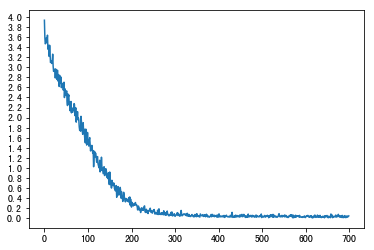

In [17]:
# 隐藏节点
hidden_size = 256

# 编码器与带注意力机制的解码器
encoder1 = EncoderRNN(input_lang.n_words, hidden_size)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, 1, dropout_p=0.1)

if use_cuda:
    encoder1 = encoder1.cuda()
    attn_decoder1 = attn_decoder1.cuda()

# 正式训练
trainIters(encoder1, attn_decoder1, 70000, print_every=5000)

我们来看看翻译的效果。

In [19]:
evaluateRandomly(encoder1, attn_decoder1)

> 我仍是这里的老板。
= i m still the boss here .
< i m still the boss here . <EOS>

> 你一直忙。
= you re always busy .
< you re always busy . <EOS>

> 他不是很擅長數學。
= he is not very good at mathematics .
< he is not very good at mathematics . <EOS>

> 她中文有进步。
= she is progressing in chinese .
< she is progressing in chinese . <EOS>

> 她既没钱，也不出名。
= she s neither rich nor famous .
< she s neither rich nor famous . <EOS>

> 我太忙了，無法幫助他。
= i m too busy to help him .
< i m too busy to help him . <EOS>

> 他是我弟弟的一個朋友。
= he s a friend of my brother s .
< he s a friend of my brother s . <EOS>

> 我来自东京。
= i m from tokyo .
< i m from tokyo . <EOS>

> 他很容易遲到。
= he is apt to be late .
< he is apt to be late . <EOS>

> 他不是美国人。
= he isn t an american .
< he is not an american . <EOS>



/explorer/pyenv/jupyter-py36/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/explorer/pyenv/jupyter-py36/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


<div id="5.2"></div>

## 5.2 Attention过程可视化

Attention机制的一个有用的特性是其高度可解释的输出。

由于它用于对输入序列的特定编码器输出进行加权，所以我们可以看出在每个时间步网络关注的位置。

通过`plt.matshow(attentions)`，将Attention输出显示为矩阵，其中列是输入步骤，行是输出步骤：

/explorer/pyenv/jupyter-py36/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/explorer/pyenv/jupyter-py36/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


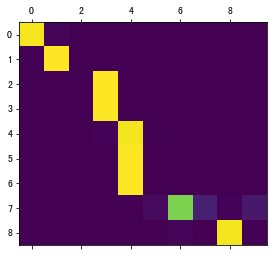

In [20]:
pair_visual = random.choice(pairs)
output_words, attentions = evaluate(
    encoder1, attn_decoder1, pair_visual[0])
plt.matshow(attentions.numpy())

为了更好的可视化体验，我们加上坐标轴标记。

/explorer/pyenv/jupyter-py36/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/explorer/pyenv/jupyter-py36/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


input = 我一點也不擔心。
output = i am not the least bit worried . <EOS>


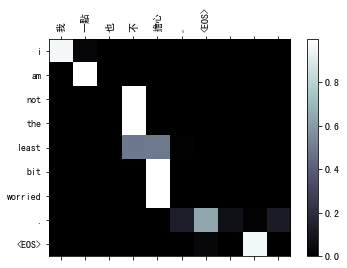

----------------------------------------------
input = 我老打你
output = i m not as you . <EOS>


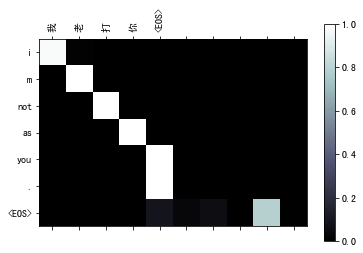

----------------------------------------------
input = 打那个狗
output = i am afraid of dogs . <EOS>


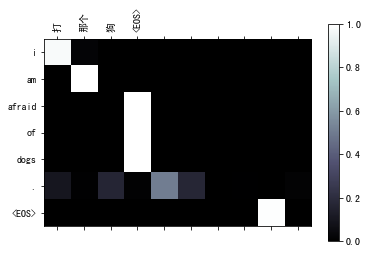

----------------------------------------------
input = 男人，就要勇敢一点
output = she s not the same hat . <EOS>


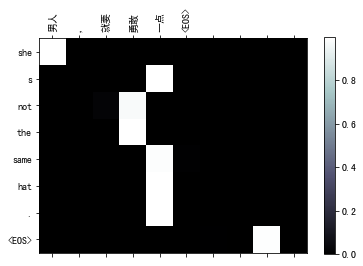

----------------------------------------------


In [21]:
# 绘制图形
def showAttention(input_sentence, output_words, attentions):
    # 设置带 colorbar 的图形
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # 设置坐标轴标记
    ax.set_xticklabels([''] + list(jieba.cut(input_sentence)) + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # 设置坐标轴标记位置
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

# Attention可视化
def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)
    print('----------------------------------------------')

# 输出四个句子进行观察分析Attention的可视化过程
evaluateAndShowAttention(pair_visual[0]) 

evaluateAndShowAttention(u'我老打你')

evaluateAndShowAttention(u'打那个狗')

evaluateAndShowAttention(u'男人，就要勇敢一点')

观察结果可以发现，由于我们的语料有限，得到的翻译器对非语料中的句子的翻译效果并不是很好。后期我们可以尝试丰富我们的语料库，使得翻译更为准确。

<div id="6"></div>

# 6 更多的尝试

由于为了快速展示模型效果，上面的训练过程一切从简，比如限制了输入和输出句子的单词数，其实我们还可以有更多的尝试：
1. 不对翻译对过滤，使用完整的数据集（可以通过增大`MAX_LENGTH`实现）
2. 使用不同的数据集
    + 另一种语言对
    + 人→机器（例如IOT命令）
    + 聊天→响应
    + 问题→回答
3. 用预先训练的词嵌入替换独热的方式，如word2vec或GloVe
4. 尝试更多的隐层，更多的隐藏单位和更多的句子。比较训练时间和结果。
5. 如果你使用的翻译文件对有两个相同的短语（I am test \ I am test），那么你可以使用这个网络作为一个自动编码器。 尝试一下过程：
 + 训练一个自动编码器
 + 只保存编码器网络
 + 训练一个新的解码器对编码器输出进行翻译